In [9]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt



def add_padding(img, target_size=(128, 128), mask=False):
    padding_value = -1 if mask else 0  # -1 für Masken, 0 für Bilder
    h, w = img.shape[:2]

    # Wenn das Bild eine Maske ist, ändern wir den Datentyp, um -1 zu akzeptieren
    dtype = np.int16 if mask else np.uint8
    if len(img.shape) == 2:  # Graustufenbild (wie Masken)
        padded_img = np.full((*target_size,), padding_value, dtype=dtype)
    else:
        padded_img = np.full((*target_size, 3), padding_value, dtype=dtype)  # für 3-Kanal Farbbild

    # Zentrales Padding
    y1 = max(0, (target_size[0] - h) // 2)
    x1 = max(0, (target_size[1] - w) // 2)

    y2 = y1 + h
    x2 = x1 + w

    padded_img[y1:y2, x1:x2] = img
    return padded_img

def crop_and_pad_component(image, mask, target_size=(128, 128)):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # Die Anzahl der Labels ist die Anzahl der gefundenen Komponenten (einschließlich des Hintergrunds)
    print(f"Anzahl der gefundenen Komponenten (einschließlich des Hintergrunds): {num_labels}")

    # Durchlaufen Sie jede Komponente und drucken Sie einige Details
    for i in range(num_labels):
        # Die Statistiken enthalten Informationen wie die linke obere Ecke (x,y) der Bounding-Box, die Breite, die Höhe und die Fläche
        x, y, w, h, area = stats[i]

    cropped_images = []
    cropped_masks = []
    for i in range(1, num_labels):  # überspringt den Hintergrund
        # Bounding Box Informationen extrahieren
        x, y, w, h, area = stats[i]

        # Prüfen, ob die Komponente relevant ist (nicht zu klein, um ein Rauschen zu sein)
        if area < 50:  # Der Schwellenwert kann je nach Bedarf angepasst werden
            continue


        # Ausschneiden
        cropped_img = image[y:y+h, x:x+w]
        cropped_msk = mask[y:y+h, x:x+w]
        # Padding hinzufügen
        padded_img = add_padding(cropped_img, target_size=target_size, mask=False)
        padded_msk = add_padding(cropped_msk, target_size=target_size, mask=True)
        # In Liste speichern
        cropped_images.append(padded_img)
        cropped_masks.append(padded_msk)
    return cropped_images, cropped_masks


Anzahl der gefundenen Komponenten (einschließlich des Hintergrunds): 13

Komponente 0:
   Position (x, y): (0, 0)
   Größe (Breite, Höhe): (128, 128)
   Fläche: 14847
   Zentroid (x, y): (63.810534114635956, 62.82198423924025)

Komponente 1:
   Position (x, y): (109, 0)
   Größe (Breite, Höhe): (6, 8)
   Fläche: 26
   Zentroid (x, y): (111.38461538461539, 3.1153846153846154)

Komponente 2:
   Position (x, y): (115, 0)
   Größe (Breite, Höhe): (13, 16)
   Fläche: 145
   Zentroid (x, y): (122.44827586206897, 6.5793103448275865)

Komponente 3:
   Position (x, y): (113, 21)
   Größe (Breite, Höhe): (3, 6)
   Fläche: 16
   Zentroid (x, y): (113.875, 23.75)

Komponente 4:
   Position (x, y): (61, 34)
   Größe (Breite, Höhe): (60, 54)
   Fläche: 373
   Zentroid (x, y): (92.12064343163539, 56.53619302949062)

Komponente 5:
   Position (x, y): (41, 43)
   Größe (Breite, Höhe): (7, 8)
   Fläche: 38
   Zentroid (x, y): (44.0, 45.55263157894737)

Komponente 6:
   Position (x, y): (0, 73)
   Größe 

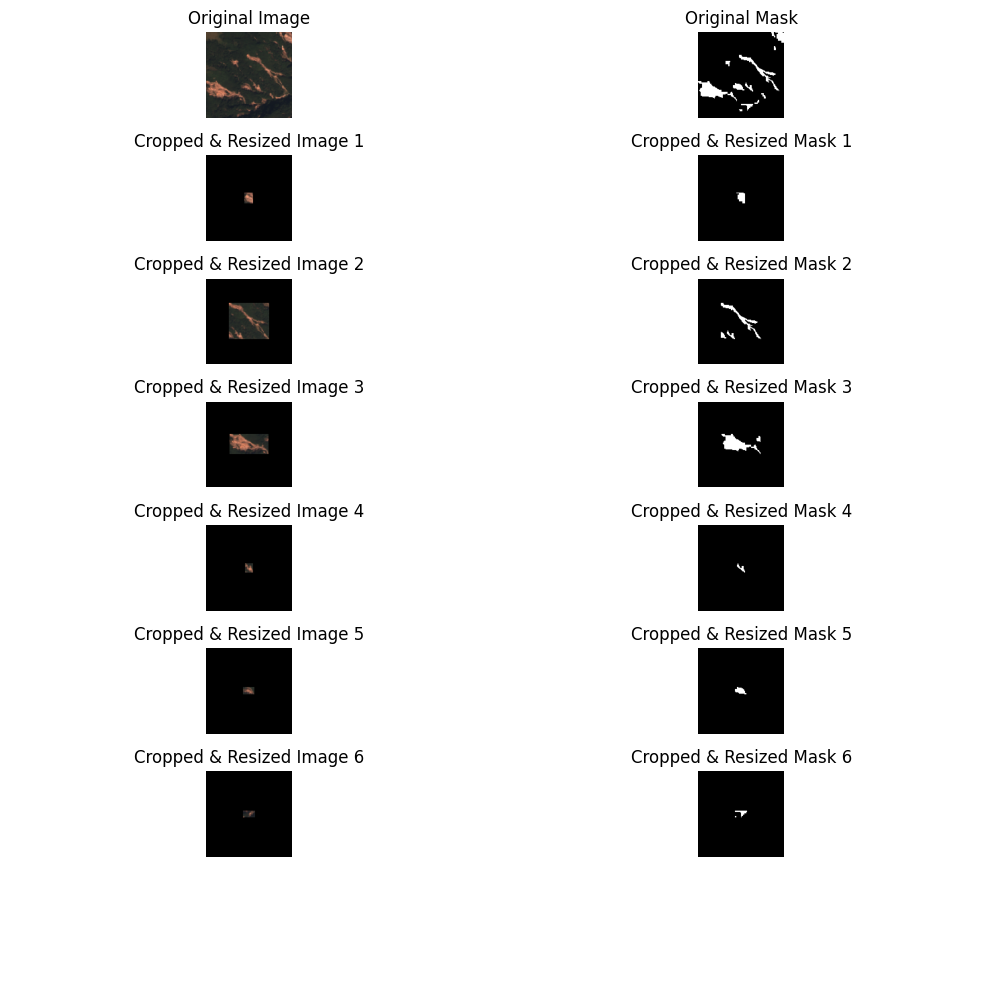

In [11]:
# Pfade zu Ihren Bildern und Masken
image_folder = 'data/train/images'
mask_folder = 'data/train/masks'

# Dateinamen der Bilder und Masken erhalten
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])

# Nehmen Sie das erste Bild und die erste Maske
first_image_filename = image_files[1]
first_mask_filename = mask_files[1]

image_path = os.path.join(image_folder, first_image_filename)
mask_path = os.path.join(mask_folder, first_mask_filename)

# Bilder und Masken laden
original_image = cv2.imread(image_path)
original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Maske in Graustufen lesen

# Überprüfen, ob das Bild und die Maske erfolgreich geladen wurden
if original_image is None or original_mask is None:
    raise ValueError("Bild oder Maske konnte nicht geladen werden.")

# Schneiden und Skalieren
cropped_padded_images, cropped_padded_masks = crop_and_pad_component(original_image, original_mask)

# Konvertieren Sie das Bild von BGR zu RGB (für Matplotlib)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Jetzt plotten wir das originale Bild und die Maske, gefolgt von den gecroppten und skalierten Bildern und Masken.
fig, axs = plt.subplots(2 + len(cropped_padded_images), 2, figsize=(10, 10))  # Anpassen der Gesamtanzahl von Reihen basierend auf der Anzahl der gecroppten Bilder

# Originalbild und Maske plotten
axs[0, 0].imshow(original_image_rgb)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

axs[0, 1].imshow(original_mask, cmap='gray')
axs[0, 1].set_title("Original Mask")
axs[0, 1].axis('off')

# Gecroppte und skalierte Bilder und Masken plotten
for i, (img, mask) in enumerate(zip(cropped_padded_images, cropped_padded_masks)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konvertieren von BGR zu RGB

    axs[1 + i, 0].imshow(img_rgb)
    axs[1 + i, 0].set_title(f"Cropped & Resized Image {i+1}")
    axs[1 + i, 0].axis('off')

    axs[1 + i, 1].imshow(mask, cmap='gray')
    axs[1 + i, 1].set_title(f"Cropped & Resized Mask {i+1}")
    axs[1 + i, 1].axis('off')

# Entfernen Sie die Achsen und leeren Plots, falls vorhanden
for ax in axs.flat:
    ax.axis('off')

# Anpassen des Layouts und Anzeigen des Plots
plt.tight_layout()
plt.show()


In [12]:
# Definieren Sie die Pfade zu Ihren Daten
image_folder = 'data/train/images'
mask_folder = 'data/train/masks'
cropped_image_folder = 'data/cropped/images'
cropped_mask_folder = 'data/cropped/masks'

In [15]:
def process_and_save_images(image_folder, mask_folder, cropped_image_folder, cropped_mask_folder):
    # Liste der Dateinamen für Bilder und Masken
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    if len(image_files) != len(mask_files):
        raise ValueError("Anzahl der Bilder und Masken stimmt nicht überein!")

    for img_file, mask_file in zip(image_files, mask_files):
        # Extrahieren der Basisnamen ohne Erweiterung
        img_base, _ = os.path.splitext(img_file)
        mask_base, _ = os.path.splitext(mask_file)

        # Extrahieren der numerischen IDs
        img_id = img_base.split('_')[-1]  # nimmt den Teil nach dem letzten Unterstrich
        mask_id = mask_base.split('_')[-1]  # nimmt den Teil nach dem letzten Unterstrich

        # Lade Bild und Maske
        image_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Standardmäßig in BGR-Format
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Maske sollte ein Einzelkanalbild sein

        # Führen Sie das Cropping und Padding durch
        cropped_images, cropped_masks = crop_and_pad_component(image, mask)

        # Speichern der bearbeiteten Bilder und Masken
        for idx, (c_img, c_mask) in enumerate(zip(cropped_images, cropped_masks)):
            # Generieren Sie neue Dateinamen
            new_img_file = f"{os.path.splitext(img_file)[0]}_cropped_{idx}{os.path.splitext(img_file)[1]}"
            new_mask_file = f"{os.path.splitext(mask_file)[0]}_cropped_{idx}{os.path.splitext(mask_file)[1]}"

            cv2.imwrite(os.path.join(cropped_image_folder, new_img_file), c_img)
            cv2.imwrite(os.path.join(cropped_mask_folder, new_mask_file), c_mask)

# Führen Sie die Funktion aus
process_and_save_images(image_folder, mask_folder, cropped_image_folder, cropped_mask_folder)

Anzahl der gefundenen Komponenten (einschließlich des Hintergrunds): 5

Komponente 0:
   Position (x, y): (0, 0)
   Größe (Breite, Höhe): (128, 128)
   Fläche: 15979
   Zentroid (x, y): (62.281682207897866, 64.1299205206834)

Komponente 1:
   Position (x, y): (127, 0)
   Größe (Breite, Höhe): (1, 1)
   Fläche: 1
   Zentroid (x, y): (127.0, 0.0)

Komponente 2:
   Position (x, y): (102, 13)
   Größe (Breite, Höhe): (26, 13)
   Fläche: 132
   Zentroid (x, y): (114.0, 18.333333333333332)

Komponente 3:
   Position (x, y): (103, 29)
   Größe (Breite, Höhe): (24, 12)
   Fläche: 163
   Zentroid (x, y): (113.04294478527608, 34.26993865030675)

Komponente 4:
   Position (x, y): (102, 62)
   Größe (Breite, Höhe): (12, 17)
   Fläche: 109
   Zentroid (x, y): (106.27522935779817, 70.14678899082568)
Anzahl der gefundenen Komponenten (einschließlich des Hintergrunds): 13

Komponente 0:
   Position (x, y): (0, 0)
   Größe (Breite, Höhe): (128, 128)
   Fläche: 14847
   Zentroid (x, y): (63.810534114635